## Introduction

This notebook describes the pre-processing of the spatial verification of the CARRA1 forecast
using Cryo Clim data.

## Pre-processing of the CARRA data
### Projecting the Cryo Clim data to a regular lat lon grid
Before comparing the CARRA forecast with the Cryo Clim data, the CARRA data is pre-processed to match the Cryo Clim grid
resolution. Since the Cryo Clim grid is coarser than the CARRA grid, the CARRA model data, with original resolution of 2.5 km is upscaled to the Cryo Clim grid.

The Cryo Clim grid has 5 km resolution on a lambert_azimuthal_equal_area projection. 
The spatial verification using the harp package works better when both grids (model and observation) are on a regular grid. For this reason the Cryo Clim data is projected first to a regular lat lon grid using the `rioxarray` library.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import xarray as xr
import rioxarray
import numpy as np
from rasterio.enums import Resampling
import os

# Open the dataset  
date = "201505011200"
data_path = "../../sample_data/Cryo_clim"
ncfile = os.path.join(data_path,f"daily-avhrr-sce-nhl_ease-50_{date}.nc")
date = ncfile.split("_")[-1].replace(".nc","")
ds = xr.open_dataset(ncfile)

# Dump only this variable
variable_name = 'prob_snow_c'
ds_single = ds[[variable_name,"lat","lon"]]

# Remove the grid_mapping attribute if it exists  
if 'grid_mapping' in ds_single[variable_name].attrs:
    del ds_single[variable_name].attrs['grid_mapping']

# Add CRS information to the dataset  
ds_single.rio.write_crs(
    "+proj=laea +ellps=WGS84 +lat_0=90 +lon_0=0",
    inplace=True
)

# Set spatial dimensions  
ds_single.rio.set_spatial_dims(x_dim="xc", y_dim="yc", inplace=True)

# Reproject to WGS84 (regular lat-lon)  
ds_reproj = ds_single.rio.reproject(
    "EPSG:4326",  # WGS84 lat-lon  
    resolution=0.05,  # Choosing 0.05 as the resolution is 5km
    resampling=Resampling.bilinear
)
# Clean up any remaining grid mapping references  
if 'grid_mapping' in ds_reproj[variable_name].attrs:
    del ds_reproj[variable_name].attrs['grid_mapping']
ds_reproj.to_netcdf(os.path.join(data_path,f'cryoreg_ll_{variable_name}_{date}.nc'))

The Cryo Clim dataset is shown below in the orignal and regular lat lon grid.

Text(0.5, 1.0, 'Cryo Clim data in regular lat lon grid')

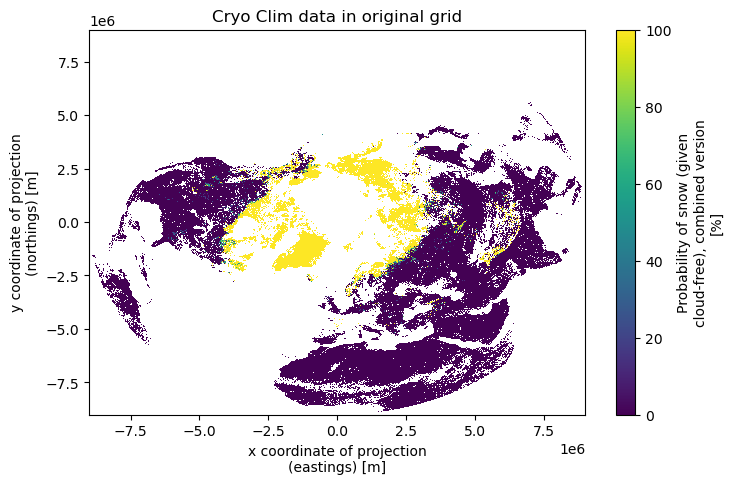

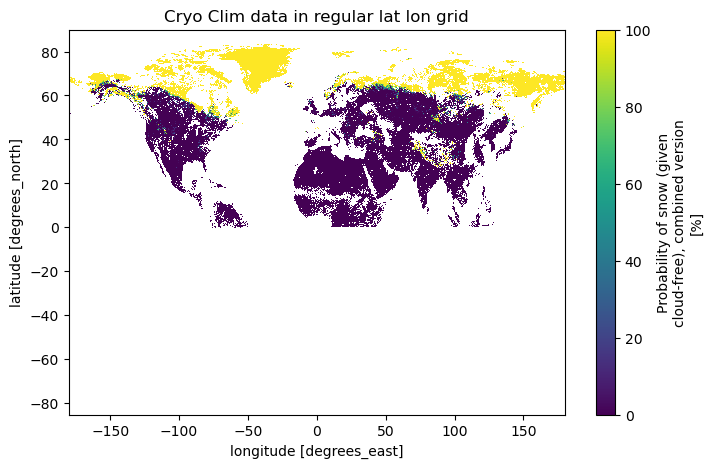

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
date = "201505011200"
variable_name = 'prob_snow_c'

data_path = "../../sample_data/Cryo_clim"
nc_original = os.path.join(data_path,f"daily-avhrr-sce-nhl_ease-50_{date}.nc")
nc_regular = os.path.join(data_path,f"cryoreg_ll_{variable_name}_{date}.nc")

plt.figure(figsize=(8, 5))
ds = xr.open_dataset(nc_original)
ds["prob_snow_c"][0,:,:].plot()# title="Cryo Clim data in original grid")
plt.title("Cryo Clim data in original grid")

plt.figure(figsize=(8, 5))
ds = xr.open_dataset(nc_regular)
ds["prob_snow_c"][0,:,:].plot() #title="Cryo Clim data in regular lat lon grid")
plt.title("Cryo Clim data in regular lat lon grid")

### Resampling the CARRA data to the Cryo Clim grid


Now we can resample the CARRA data to the Cryo Clim grid. 
The resampling is done using the python library `pyresample`. The code below reads the CARRA and Cryo Clim data 
on their respective regular grids and performs the resampling of CARRA to the Cryo Clim grid.

First we define a few functions that will be used to resample the data.

In [3]:
import os
import sys
import datetime
import xarray as xr
import pyresample as pr
import numpy as np
from netCDF4 import Dataset

from pyproj import Transformer


def seconds_to_unix_time(seconds_since_1978):
    """
    Convert seconds since January 1, 1978 to Unix timestamp.

    Args:
        seconds_since_1978 (int): Number of seconds since January 1, 1978.

    Returns:
        float: Corresponding Unix timestamp.
    """
    base_datetime = datetime.datetime(1978, 1, 1, 0, 0, 0)
    target_datetime = base_datetime + datetime.timedelta(seconds=seconds_since_1978)
    return target_datetime.timestamp()
def get_geom_def(input_file, harmonie_file):
    """
    This function generates the geometric definitions required for resampling data from a source grid (HARMONIE) 
    to a target grid (subset of NetCDF grid). It reads the input NetCDF files, extracts the latitude and longitude 
    values, and creates the source and target grid definitions.
    Parameters:
    input_file (str): Path to the input NetCDF file.
    harmonie_file (str): Path to the HARMONIE NetCDF file.
    Returns:
    tuple: A tuple containing the following elements:
        - src_def (pyresample.geometry.SwathDefinition): Source grid definition based on HARMONIE data.
        - target_def (pyresample.geometry.GridDefinition): Target grid definition based on the subset of NetCDF data.
        - orig_def (pyresample.geometry.GridDefinition): Original grid definition based on the NetCDF data.
        - flip_y (numpy.ndarray): Flipped y-coordinates of the target grid.
        - unique_x (numpy.ndarray): Unique x-coordinates of the target grid.
    input_file, harmonie_file):
    
    """
    # Open input datasets
    nc = xr.open_dataset(input_file)
    ds_harm = xr.open_dataset(harmonie_file)
    

    # Create source definition (HARMONIE grid)
    harm_lat = ds_harm["latitude"].values
    harm_lon = ds_harm["longitude"].values

    harm_lon, harm_lat = np.meshgrid(harm_lon, harm_lat)
    src_def = pr.geometry.SwathDefinition(lons=harm_lon, lats=harm_lat)

    # Get the domain bounds from HARMONIE
    lat_min = harm_lat.min()
    lat_max = harm_lat.max()
    lon_min = harm_lon.min()
    lon_max = harm_lon.max()

    print("Borders of the harmonie grid")
    print(lat_min,lat_max)
    print(lon_min,lon_max)
    nc_lat = nc.lat.values  # This is already 2D
    nc_lon = nc.lon.values  # This is already 2D

    orig_def = pr.geometry.GridDefinition(lons = nc_lon, lats = nc_lat)
    #this one considers only the lat min and max to avoid issues with
    # the lon min and max. The lon min and max are handled later

    domain_mask = (nc_lat >= lat_min) & (nc_lat <= lat_max)

    # Get the corresponding x and y indices where the mask is True
    y_indices, x_indices = np.where(domain_mask)

    # Get the unique x and y coordinates that fall within our domain
    unique_x = np.unique(nc.x.values[x_indices])
    unique_y = np.unique(nc.y.values[y_indices])

    # Create the target grid definition using the masked coordinates
    x_grid, y_grid = np.meshgrid(unique_x, unique_y)

    # Get corresponding lat/lon for these points
    target_lat = nc_lat[np.ix_(range(len(unique_y)), range(len(unique_x)))]
    target_lon = nc_lon[np.ix_(range(len(unique_y)), range(len(unique_x)))]
    target_def = pr.geometry.GridDefinition(lons=target_lon, lats=target_lat)
    #print("Borders of the resulting mesh")
    #print(unique_y.min(),unique_y.max())
    #print(unique_x.min(),unique_x.max())
    flip_y = np.flip(unique_y) #for some reason this is inverted!!
    return src_def, target_def, orig_def, flip_y, unique_x

def upsample_snowcover_carra_to_metgrid(
    input_file, harmonie_file, obs_var="prob_snow_c", var_out="prob_snow_c", model_var="fscov", prob_snow_thr=80.0
):
    """
    This function reads the input NetCDF file containing snow cover data from CARRA, and resamples the data to the
    Met Norway grid using the HARMONIE data as the source grid. The resampled data is then saved to a new NetCDF file.  
    Parameters: 

    input_file (str): Path to the input NetCDF file containing snow cover data from CARRA.
    harmonie_file (str): Path to the HARMONIE GRIB file.
    obs_var (str): Name of the variable in the input NetCDF file.
    var_out (str): Name of the output variable in the new NetCDF file.
    model_var (str): Name of the variable in the HARMONIE GRIB file.
    prob_snow_thr (float): Threshold value for snow cover probability.
    Returns:
    tuple: A tuple containing the following elements:
        - data_out (numpy.ndarray): Resampled snow cover data.
        - ds (xarray.Dataset): Output dataset containing the resampled data.
    """

    nc = xr.open_dataset(input_file)
    ds_harm = xr.open_dataset(harmonie_file)


    src_def,target_def, orig_def, target_lat, target_lon = get_geom_def(input_file, harmonie_file)
# Resample data
    data_in = ds_harm[model_var].values
    #bin_data_in = np.where((~np.isnan(data_in)) & (data_in > prob_snow_thr), 1, 0)
    times = ds_harm["time"].values
    # Using average resampling for downscaling
    data_out = pr.kd_tree.resample_nearest(
        src_def,
        #bin_data_in, #usig this I get a NaN error
        data_in,
        target_def,
        radius_of_influence=50000, #this is the default value!
        #sigmas=25000,
        fill_value=np.nan
    )
    # Process time values
    reference_date = np.datetime64("1978-01-01T00:00:00.0000")
    times = np.atleast_1d(times)
    seconds_since_1978 = [(t - reference_date) / np.timedelta64(1, "s") for t in times]
    std_unix_time = [seconds_to_unix_time(ts) for ts in seconds_since_1978]

    # Reshape data for output
    #n_time = len(times)
    if len(data_out.shape) == 2:
        data_out = data_out.reshape(1, *data_out.shape)

    # Create binary snow cover data
    bin_data = np.where((~np.isnan(data_out)) & (data_out > prob_snow_thr), 1, 0)
        # Create output dataset
    ds = xr.Dataset(
        {
            var_out: (["time", "lat", "lon"], data_out),
            "bin_snow": (["time", "lat", "lon"], bin_data),
        },
        coords={
            "time": std_unix_time,
            "lat": target_lat,
            "lon": target_lon,
            #"lat": ds_harm["latitude"].values,
            #"lon": ds_harm["longitude"].values,
        },
    )


    return data_out, ds
def dump_to_nc(ds,output_file):

    """
    Save the resampled data to a NetCDF file.

    Parameters:
        ds (xarray.Dataset): Output dataset containing the resampled data.
        output_file (str): Path to the output NetCDF file.
            
    """
    ds.time.attrs.update(
        {
            "units": "seconds since 1970-01-01 00:00:00",
            "long_name": "reference time of product",
        }
    )
    ds.lon.attrs["units"] = "degrees_east"
    ds.lat.attrs["units"] = "degrees_north"
    ds[var_out].attrs["units"] = "None"
    ds["bin_snow"].attrs.update(
        {"units": "None", "coordinates": "lat lon", "grid_mapping": "longlat"}
    )

    # Set grid mapping attributes
    # Set attributes
    ds.time.attrs.update(
        {
            "units": "seconds since 1970-01-01 00:00:00",
            "long_name": "reference time of product",
        }
    )
    ds.lon.attrs["units"] = "degrees_east"
    ds.lat.attrs["units"] = "degrees_north"
    ds[var_out].attrs["units"] = "None"
    ds["bin_snow"].attrs.update(
        {"units": "None", "coordinates": "lat lon", "grid_mapping": "longlat",
         "proj4": "+proj=longlat +datum=WGS84"}
    )
    # Save to NetCDF
    ds.to_netcdf(output_file)
    # Add projection information
    with Dataset(output_file, "a", format="NETCDF4") as fid:
        proj_var = fid.createVariable("projection_regular_ll", "i4", ())
        proj_var.grid_mapping_name = "longlat"
        proj_var.false_northing = 0.0
        proj_var.earth_shape = "spherical"
        proj_var.proj4 = "+proj=longlat +datum=WGS84"


The resampling is done below for the CARRA data.

In [4]:
obs_var = "prob_snow_c"
var_out = "fscov"
model_var = "fscov"
prob_snow_thr = 0.8
date = "20150501"

ORIGIN="NO-AR-CW"
harmonie_file=f"../../sample_data/CARRA1/260289_{date}_analysis_{ORIGIN}_reg.grib2"


input_file="../../sample_data/Cryo_clim/reg_ll_prob_snow_c_date.nc"
output_file=f"carra_fscov_cryo_clim_grid_{date}_{ORIGIN}.nc"


ds_harm = xr.open_dataset(harmonie_file)
lon_min = ds_harm.longitude.min().item()
lon_max = ds_harm.longitude.max().item()

# resample the CARRA data to the Cryo Clim grid
data_out,ds = upsample_snowcover_carra_to_metgrid(
        input_file, harmonie_file, obs_var, var_out, model_var,prob_snow_thr
        )

# subset the data to the domain of the Cryo Clim data, handling the case where the domain crosses the 0° longitude line
if lon_min < lon_max:
    # Simple case: lon_min to lon_max is continuous
    subset = ds.sel(lon=slice(lon_min, lon_max))
else:
    # Case where the range crosses the 0° longitude line
    subset = xr.concat(
        [ds.sel(lon=slice(lon_min, 360)), ds.sel(lon=slice(0, lon_max))],
        dim="lon"
        )

# dump the data to a netcdf file
subset.to_netcdf(output_file)

Ignoring index file '../../sample_data/CARRA1/260289_20150501_analysis_NO-AR-CW_reg.grib2.923a8.idx' older than GRIB file
Ignoring index file '../../sample_data/CARRA1/260289_20150501_analysis_NO-AR-CW_reg.grib2.923a8.idx' older than GRIB file
Ignoring index file '../../sample_data/CARRA1/260289_20150501_analysis_NO-AR-CW_reg.grib2.923a8.idx' older than GRIB file


Borders of the harmonie grid
55.9 86.0
-109.69999999999999 37.7


Plotting the data

Ignoring index file '../../sample_data/CARRA1/260289_20150501_analysis_NO-AR-CW_reg.grib2.923a8.idx' older than GRIB file


Text(0.5, 1.0, 'fscov in original grid')

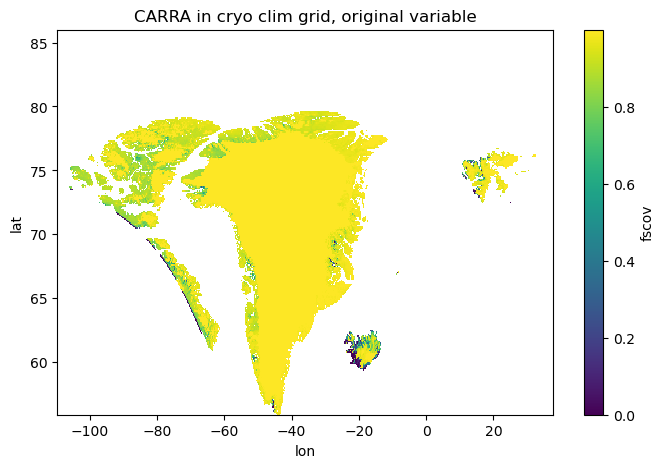

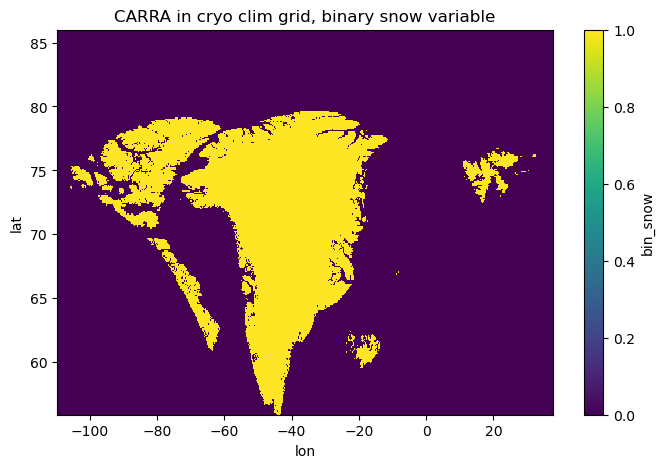

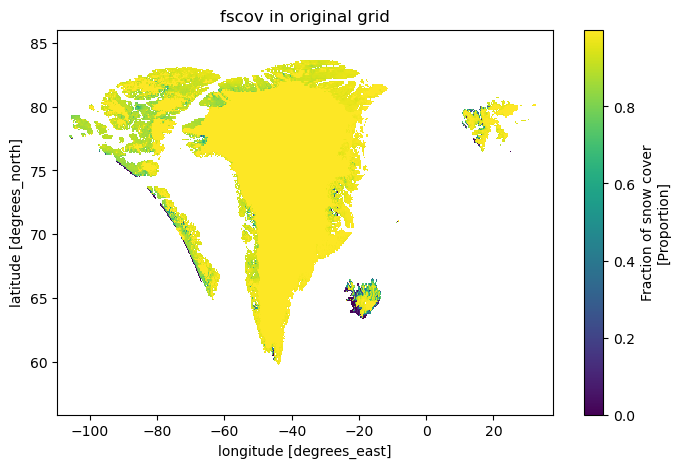

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
date = "20150501"
HH="1200"
ORIGIN="NO-AR-CW"
variable_name = 'prob_snow_c'

data_path = "../../sample_data/Cryo_clim"
cryo_file = os.path.join(data_path,f"cryoreg_ll_{variable_name}_{date}.nc")
carra_file=f"carra_fscov_cryo_clim_grid_{date}_{ORIGIN}.nc"

plt.figure(figsize=(8, 5))
ds = xr.open_dataset(carra_file)
ds["fscov"][0,:,:].plot()
plt.title("CARRA in cryo clim grid, original variable")

plt.figure(figsize=(8, 5))
ds = xr.open_dataset(carra_file)
ds["bin_snow"][0,:,:].plot()
plt.title("CARRA in cryo clim grid, binary snow variable")

harmonie_file=f"../../sample_data/CARRA1/260289_{date}_analysis_{ORIGIN}_reg.grib2"

plt.figure(figsize=(8, 5))
ds = xr.open_dataset(harmonie_file)
ds["fscov"][:,:].plot()
plt.title("fscov in original grid")


#plt.figure(figsize=(8, 5))
#ds = xr.open_dataset(nc_regular)
#ds["prob_snow_c"][0,:,:].plot() #title="Cryo Clim data in regular lat lon grid")
#plt.title("Cryo Clim data in regular lat lon grid")